# Install/Import the necessary packages 

In [1]:
import sys
!pip install torch
!pip install watermark
!pip install transformers
!pip install --upgrade pytorch-lightning
!pip install colored

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 38.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 35.0 MB/s 
     |████████████████████████████████| 6.6 MB 54.1 MB/s 
     |████████████████████████████████| 120 kB 78.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 705 kB 32.7 MB/s 
     |████████████████████████████████| 419 kB 101.9 MB/s 
     |████████████████████████████████| 5.9 MB 88.4 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency r

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch

import torchmetrics
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

# HAVING TROUBLE IMPORTING THIS SECTION (commented out - Noor)

import pytorch_lightning as pl
from torchmetrics.functional import accuracy, auroc
from torchmetrics.functional import f1_score
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
pl.seed_everything(RANDOM_SEED)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


42

Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# read in data 
df = pd.read_csv('/content/drive/MyDrive/Capstone Project/Data/multi_label_new.csv')

Data Preview 

In [5]:
df

,tweet,neutral,general criticism,disability shaming,racial prejudice,sexism,lgbtq+ phobic
0,RT @bender3395: I'm never playing flappy bird ...,0,0,0,0,0,1
1,RT @JackBPR: Alec Baldwin mocks Harris-Perry: ...,0,0,0,0,0,1
2,Gay ass hillbilly intro song,0,0,0,0,0,1
3,Photo: Giving you that trailer park trash. #tr...,0,0,0,0,0,1
4,I uploaded a @YouTube video http://t.co/JHUuZp...,0,0,0,0,0,1
...,...,...,...,...,...,...,...
23467,I love watching birds migrate. Wish I understo...,1,0,0,0,0,0
23468,@stevedischiavi Thanks 'Walking Dead' Bro Stev...,1,0,0,0,0,0
23469,"Mark Teixeira finally stepping up, HR and coup...",1,0,0,0,0,0
23470,Yellow jackets at gas station trash cans are T...,0,1,0,0,0,0


Remove Duplicates and Drop NAs

In [6]:
len(df)

23472

In [7]:
# remove duplicate tweets and drop NAs
df.drop_duplicates(subset='tweet',inplace=True)
df = df.dropna()

In [8]:
len(df)

22636

Convert label data to int 

In [9]:
# change all category types to int
df.loc[:,'neutral'] = df.loc[:,'neutral'].astype(int)
df.loc[:,'general criticism'] = df.loc[:,'general criticism'].astype(int)
df.loc[:,'disability shaming'] = df.loc[:,'disability shaming'].astype(int)
df.loc[:,'racial prejudice'] = df.loc[:,'racial prejudice'].astype(int)
df.loc[:,'sexism']=df.loc[:,'sexism'].astype(int)
df.loc[:,'lgbtq+ phobic']=df.loc[:,'lgbtq+ phobic'].astype(int)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [10]:
df

,tweet,neutral,general criticism,disability shaming,racial prejudice,sexism,lgbtq+ phobic
0,RT @bender3395: I'm never playing flappy bird ...,0,0,0,0,0,1
1,RT @JackBPR: Alec Baldwin mocks Harris-Perry: ...,0,0,0,0,0,1
2,Gay ass hillbilly intro song,0,0,0,0,0,1
3,Photo: Giving you that trailer park trash. #tr...,0,0,0,0,0,1
4,I uploaded a @YouTube video http://t.co/JHUuZp...,0,0,0,0,0,1
...,...,...,...,...,...,...,...
23467,I love watching birds migrate. Wish I understo...,1,0,0,0,0,0
23468,@stevedischiavi Thanks 'Walking Dead' Bro Stev...,1,0,0,0,0,0
23469,"Mark Teixeira finally stepping up, HR and coup...",1,0,0,0,0,0
23470,Yellow jackets at gas station trash cans are T...,0,1,0,0,0,0


# Preprocessing

In [11]:
import re

# remove urls from any tweets, remove usernames ("@etc"), emojis, and remove all numbers 
def clean_data(dataframe, column):
  dataframe[column] = dataframe[column].apply(lambda tweet: re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", tweet))
  dataframe[column] = dataframe[column].apply(lambda tweet: re.sub('@[^\s]+','',tweet))
  dataframe[column] = dataframe[column].replace(to_replace=r'\d+', value='', regex = True)
  # Removing punctuation:
  dataframe[column] = dataframe[column].str.replace('[^A-Za-z0-9 ]+','')
  # removing emojis 
  emoji_pattern = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)
  dataframe[column] = dataframe[column].apply(lambda tweet: emoji_pattern.sub(r'', tweet)) # no emoji
  # removing RT from tweets
  dataframe[column] = dataframe[column].apply(lambda tweet: tweet.replace('RT', ''))
  return dataframe

clean_data(df, 'tweet')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,tweet,neutral,general criticism,disability shaming,racial prejudice,sexism,lgbtq+ phobic
0,Im never playing flappy bird again ever fuck...,0,0,0,0,0,1
1,Alec Baldwin mocks HarrisPerry If I cry will...,0,0,0,0,0,1
2,Gay ass hillbilly intro song,0,0,0,0,0,1
3,Photo Giving you that trailer park trash trans...,0,0,0,0,0,1
4,I uploaded a video UPDATE ON UGANDA ANTIGAY...,0,0,0,0,0,1
...,...,...,...,...,...,...,...
23467,I love watching birds migrate Wish I understoo...,1,0,0,0,0,0
23468,Thanks Walking Dead Bro Steve For MendUSMC DoG,1,0,0,0,0,0
23469,Mark Teixeira finally stepping up HR and coupl...,1,0,0,0,0,0
23470,Yellow jackets at gas station trash cans are T...,0,1,0,0,0,0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


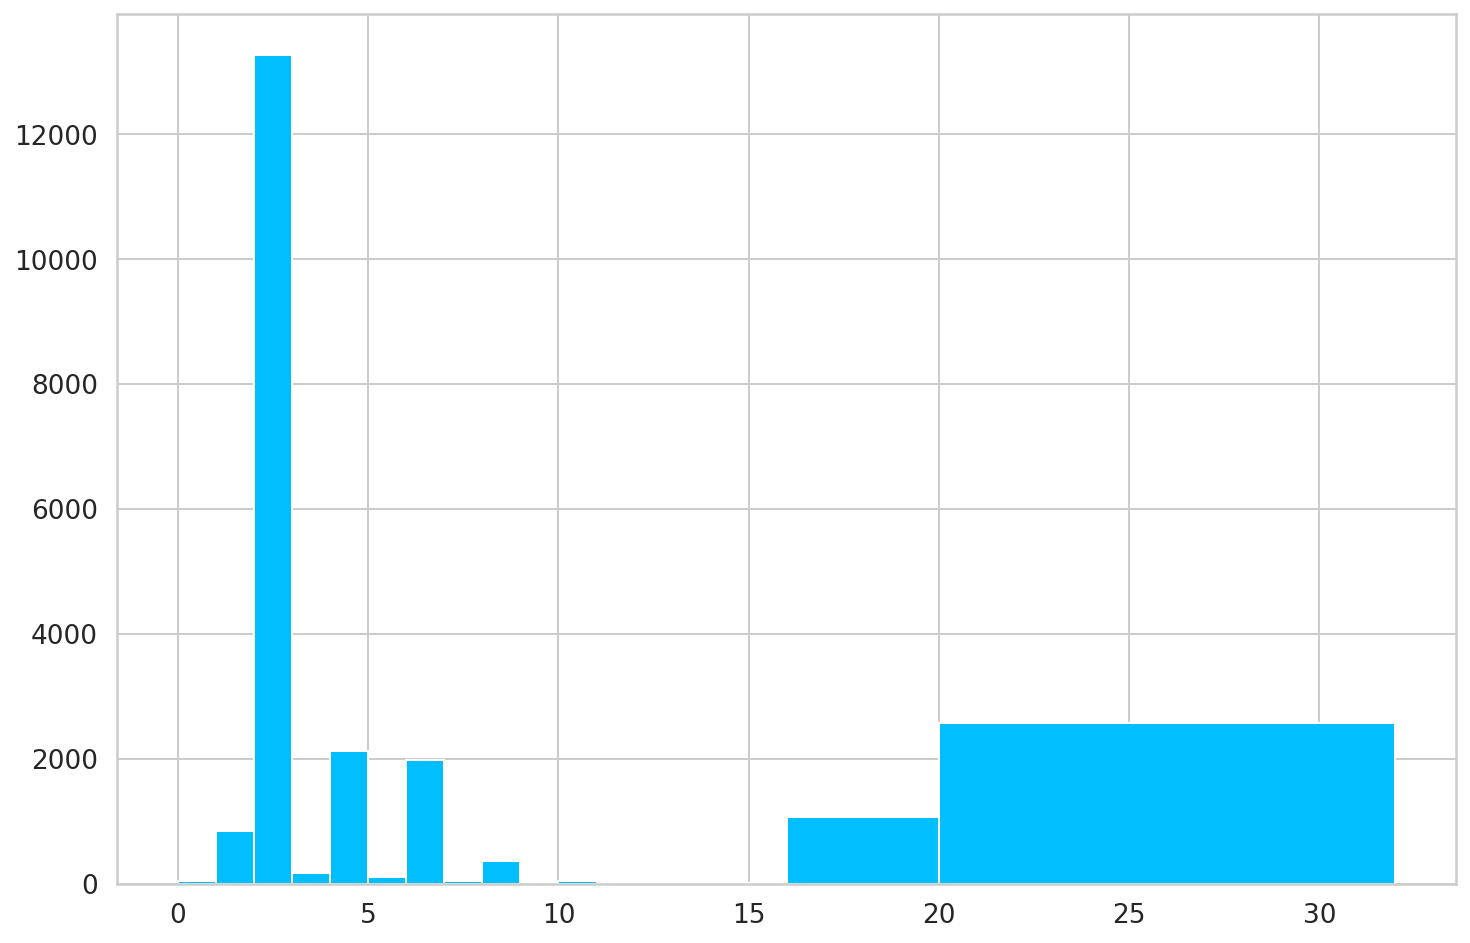

In [ ]:
# apply a label powerset transformation
#Applying Label Powerset Tranformation


# df['powerlabel'] = df.apply(lambda x : 32*x['neutral'] + 16*x["general criticism"]+8*x['disability shaming']+ 4*x['racial prejudice']+ 2*x['sexism']+ 1*x['lgbtq+ phobic'], axis=1)

# df['powerlabel'].hist(bins=np.unique(df['powerlabel']))

In [12]:
def split_data(dataframe):
  train_df, val_df = train_test_split(dataframe, test_size=0.05)
  return train_df, val_df

train_df, val_df = split_data(df)


train_df.shape, val_df.shape

((21504, 7), (1132, 7))

Looking at Distribution of the Labels 

In [13]:
train_df

,tweet,neutral,general criticism,disability shaming,racial prejudice,sexism,lgbtq+ phobic
326,mickeyblowsyourmind who wants to be a skype gr...,0,0,0,0,0,1
5024,When you see about to fight a bitch,0,0,0,0,1,0
19450,woof woof,1,0,0,0,0,0
22795,Charlie Daniels couldve done a better job MNF,1,0,0,0,0,0
12140,RayRice is a bitch JustSaying,0,0,0,0,1,0
...,...,...,...,...,...,...,...
12018,I heard thigh gaps is a way of telling if a b...,0,0,0,0,1,0
22403,Michael Pineda hides pine taron his neck fa...,0,1,0,0,0,0
5442,Both yall pussy son beat it,0,0,0,0,1,0
901,I can tell from this tweet that youre a twat,0,0,0,0,1,0


In [14]:
df.columns[1:]

Index(['neutral', 'general criticism', 'disability shaming',
       'racial prejudice', 'sexism', 'lgbtq+ phobic'],
      dtype='object')

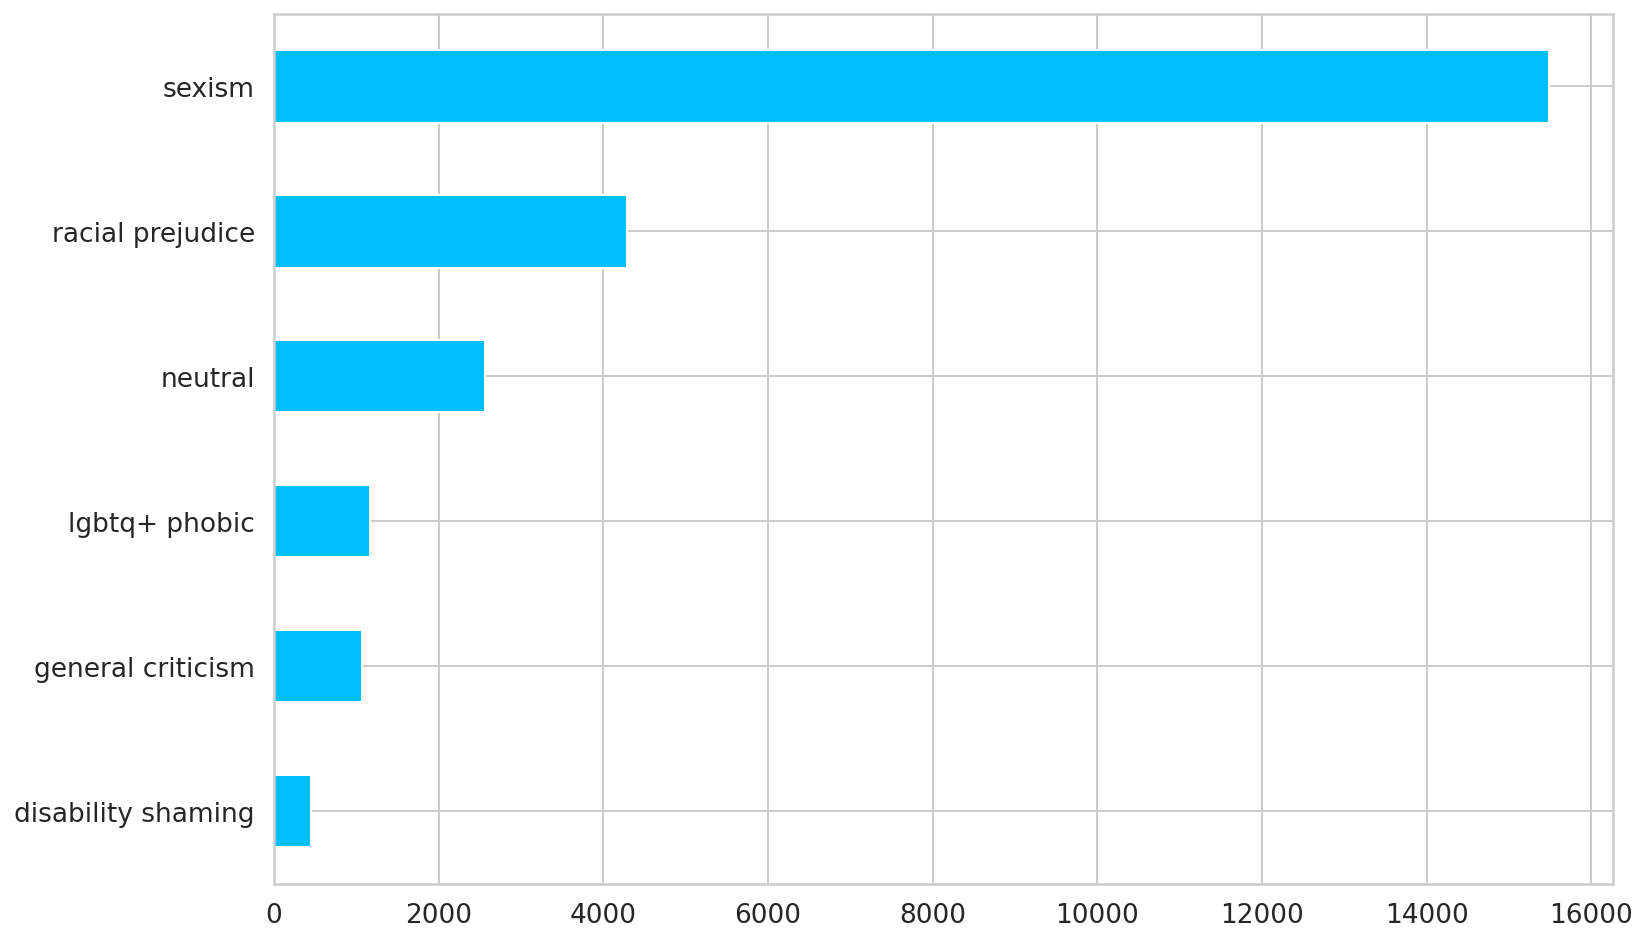

In [15]:
LABEL_COLUMNS = df.columns.tolist()[1:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

# Tokenization 

In [16]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Test it out on a sample tweet 

In [17]:
sample_row = df.iloc[16]
sample_comment = sample_row.tweet
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print()
print(sample_labels.to_dict())


 For the record NoHomo but dont care who is unless I gotta see it same with every sexuality even birds dogs what not

{'neutral': 0, 'general criticism': 0, 'disability shaming': 0, 'racial prejudice': 0, 'sexism': 0, 'lgbtq+ phobic': 1}


In [18]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [19]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

The result of the encoding is a dictionary with token ids input_ids and an attention mask attention_mask (which tokens should be used by the model 1 - use or 0 - don’t use).

Let’s look at their contents:

In [20]:
encoding["input_ids"].squeeze()[:20]

tensor([  101,  1370,  1103,  1647,  1302,  3048, 18445,  1133,  1274,  1204,
         1920,  1150,  1110,  4895,   146, 13224,  1267,  1122,  1269,  1114])

In [21]:
encoding["attention_mask"].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

You can also inverse the tokenization and get back (kinda) the words from the token ids:

In [22]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'For', 'the', 'record', 'No', '##H', '##omo', 'but', 'don', '##t', 'care', 'who', 'is', 'unless', 'I', 'gotta', 'see', 'it', 'same', 'with']


We need to specify the maximum number of tokens when encoding (512 is the maximum we can do). Let’s check the number of tokens per tweet:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


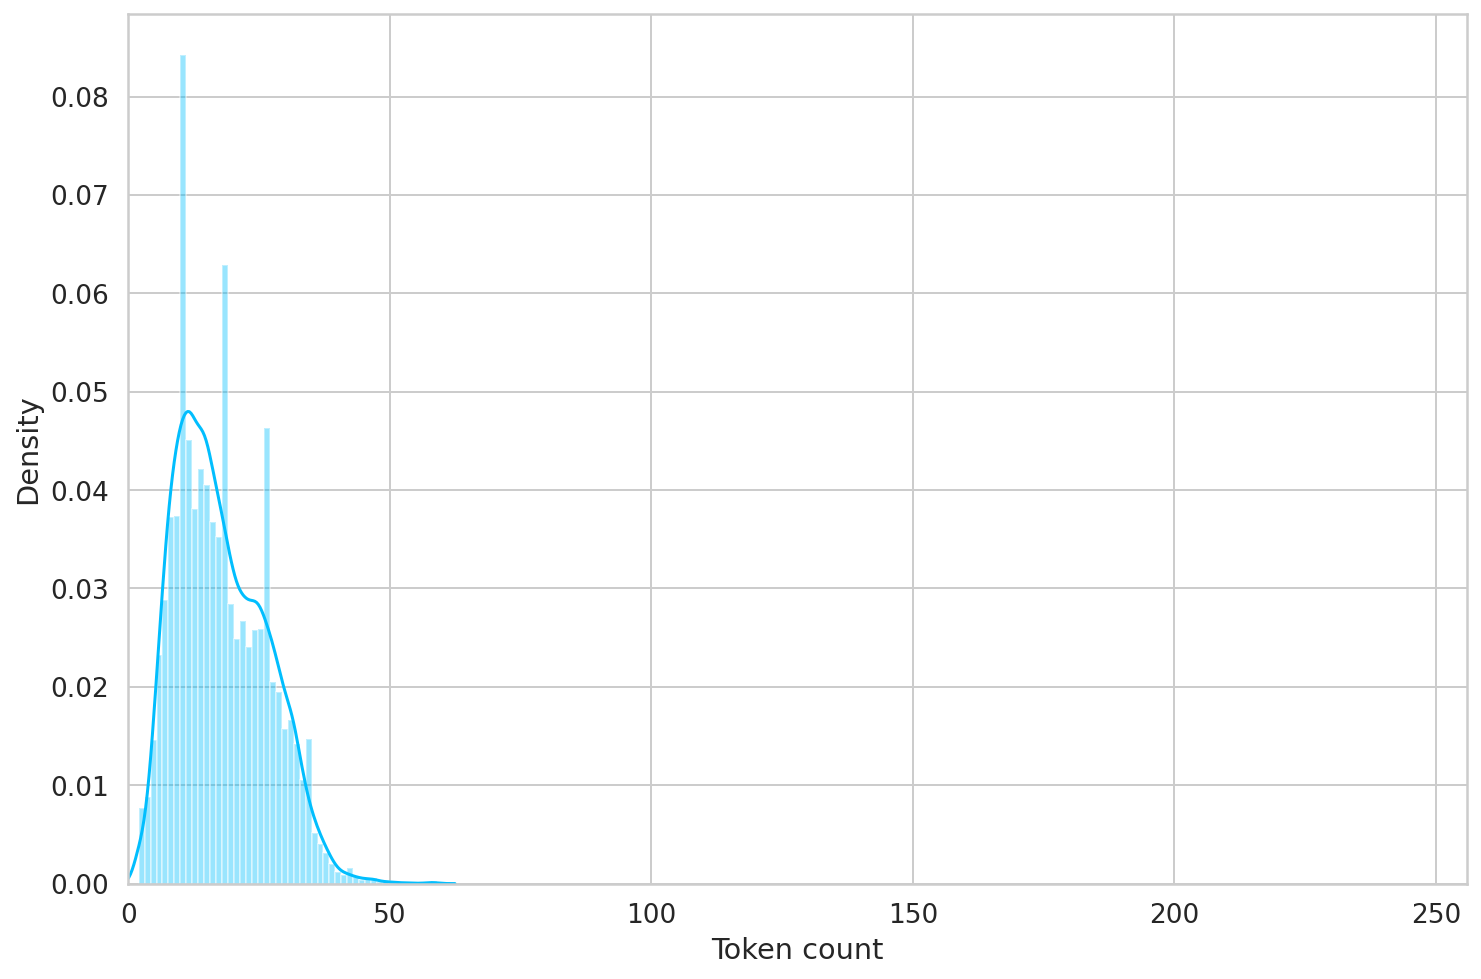

In [23]:
token_counts = []
for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row['tweet'],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)

sns.distplot(token_counts)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the tweets contain less than 50 tokens. So, we’ll stick with the limit of 50.

In [24]:
MAX_TOKEN_COUNT = 50

# Dataset 

We’ll wrap the tokenization process in a PyTorch Dataset, along with converting the labels to tensors:

In [25]:
class TweetsDataset(Dataset):
  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 128
    # max_token_len: int = 60
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    comment_text = data_row.tweet
    labels = data_row[LABEL_COLUMNS]
    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

Let’s have a look at a sample item from the dataset:

In [26]:
train_dataset = TweetsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
sample_item = train_dataset[0]
sample_item.keys()


dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [27]:
sample_item["comment_text"]

'mickeyblowsyourmind who wants to be a skype group with a bunch of offensive new york city queer folk Me  '

In [28]:
sample_item["labels"]

tensor([0., 0., 0., 0., 0., 1.])

In [29]:
sample_item["input_ids"].shape

torch.Size([50])

Let’s load the BERT model and pass a sample of batch data through:

In [30]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(torch.Size([8, 50]), torch.Size([8, 50]))

In [31]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 50, 768]), torch.Size([8, 768]))

The 768 dimension comes from the BERT hidden size:

In [32]:
bert_model.config.hidden_size

768

The larger version of BERT has more attention heads and a larger hidden size.

We’ll wrap our custom dataset into a LightningDataModule:

In [33]:
class TweetsDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
  def setup(self, stage=None):
    self.train_dataset = TweetsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )
    self.test_dataset = TweetsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )
  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=8
    )
  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=8
    )
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=8
    )

TweetsDataModule encapsulates all data loading logic and returns the necessary data loaders. Let’s create an instance of our data module:

In [34]:
N_EPOCHS = 2
BATCH_SIZE = 32
data_module = TweetsDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)


# Model

Our model will use a pre-trained BertModel and a linear layer to convert the BERT representation to a classification task. We’ll pack everything in a LightningModule:

In [35]:
class TweetTagger(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss
  def training_epoch_end(self, outputs):
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )


# Optimizer Scheduler 

The job of a scheduler is to change the learning rate of the optimizer during training. This might lead to better performance of our model. We’ll use the get_linear_schedule_with_warmup.

Let’s have a look at a simple example to make things clearer:



/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


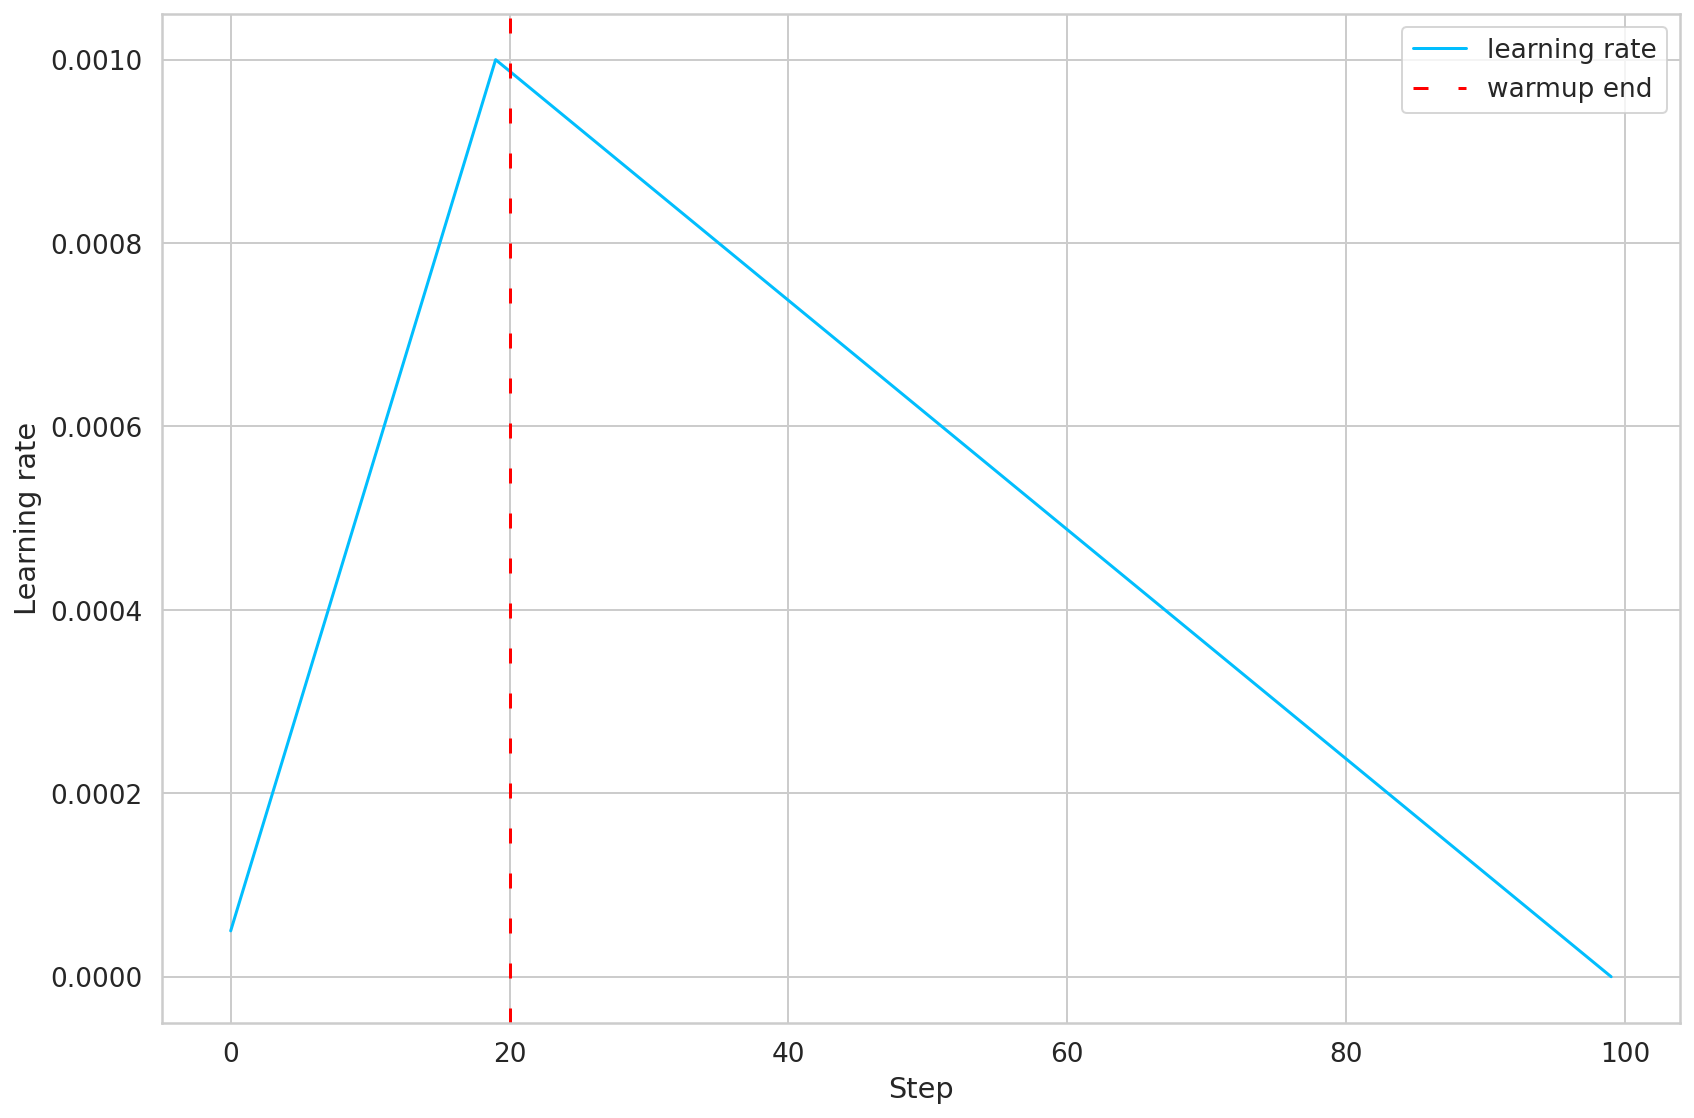

In [36]:
dummy_model = nn.Linear(2, 1)
optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)
warmup_steps = 20
total_training_steps = 100
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)
learning_rate_history = []
for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();


We simulate 100 training steps and tell the scheduler to warm up for the first 20. The learning rate grows to the initial fixed value of 0.001 during the warm-up and then goes down (linearly) to 0.

To use the scheduler, we need to calculate the number of training and warm-up steps. The number of training steps per epoch is equal to number of training examples / batch size. The number of total training steps is training steps per epoch * number of epochs:

In [37]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

**We’ll** use a fifth of the training steps for a warm-up:

In [38]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(268, 1344)

We can now create an instance of our model:



In [39]:
model = TweetTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Evaluation 

Multi-label classification boils down to doing binary classification for each label/tag.

We’ll use Binary Cross Entropy to measure the error for each label. PyTorch has BCELoss, which we’re going to combine with a sigmoid function (as we did in the model implementation). Let’s look at an example:

In [40]:
criterion = nn.BCELoss()
prediction = torch.FloatTensor(
  [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)
labels = torch.FloatTensor(
  [1., 0., 0., 0., 1., 0.]
)

In [41]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [42]:
criterion(torch.sigmoid(prediction), labels)


tensor(0.8725)

We can use the same approach to calculate the loss of the predictions:



In [43]:
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

tensor([[0.5588, 0.5227, 0.3520, 0.3689, 0.5085, 0.4888],
        [0.5658, 0.5292, 0.3459, 0.3738, 0.5128, 0.5010],
        [0.5711, 0.5234, 0.3446, 0.3722, 0.4740, 0.5151],
        [0.5532, 0.5278, 0.3379, 0.3861, 0.4857, 0.5067],
        [0.5534, 0.5311, 0.3506, 0.3613, 0.5194, 0.4809],
        [0.5651, 0.5227, 0.3390, 0.3648, 0.5081, 0.5029],
        [0.5685, 0.5234, 0.3593, 0.3783, 0.5157, 0.4779],
        [0.5492, 0.5148, 0.3629, 0.3834, 0.4861, 0.4920]],
       grad_fn=<SigmoidBackward0>)

In [44]:
criterion(predictions, sample_batch["labels"])

tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)

# ROC Curve 

Another metric we’re going to use is the area under the Receiver operating characteristic (ROC) for each tag. ROC is created by plotting the True Positive Rate (TPR) vs False Positive Rate (FPR):


TPR= 
TP+FN
TP
​
 

FPR= 
FP+TN
FP
​


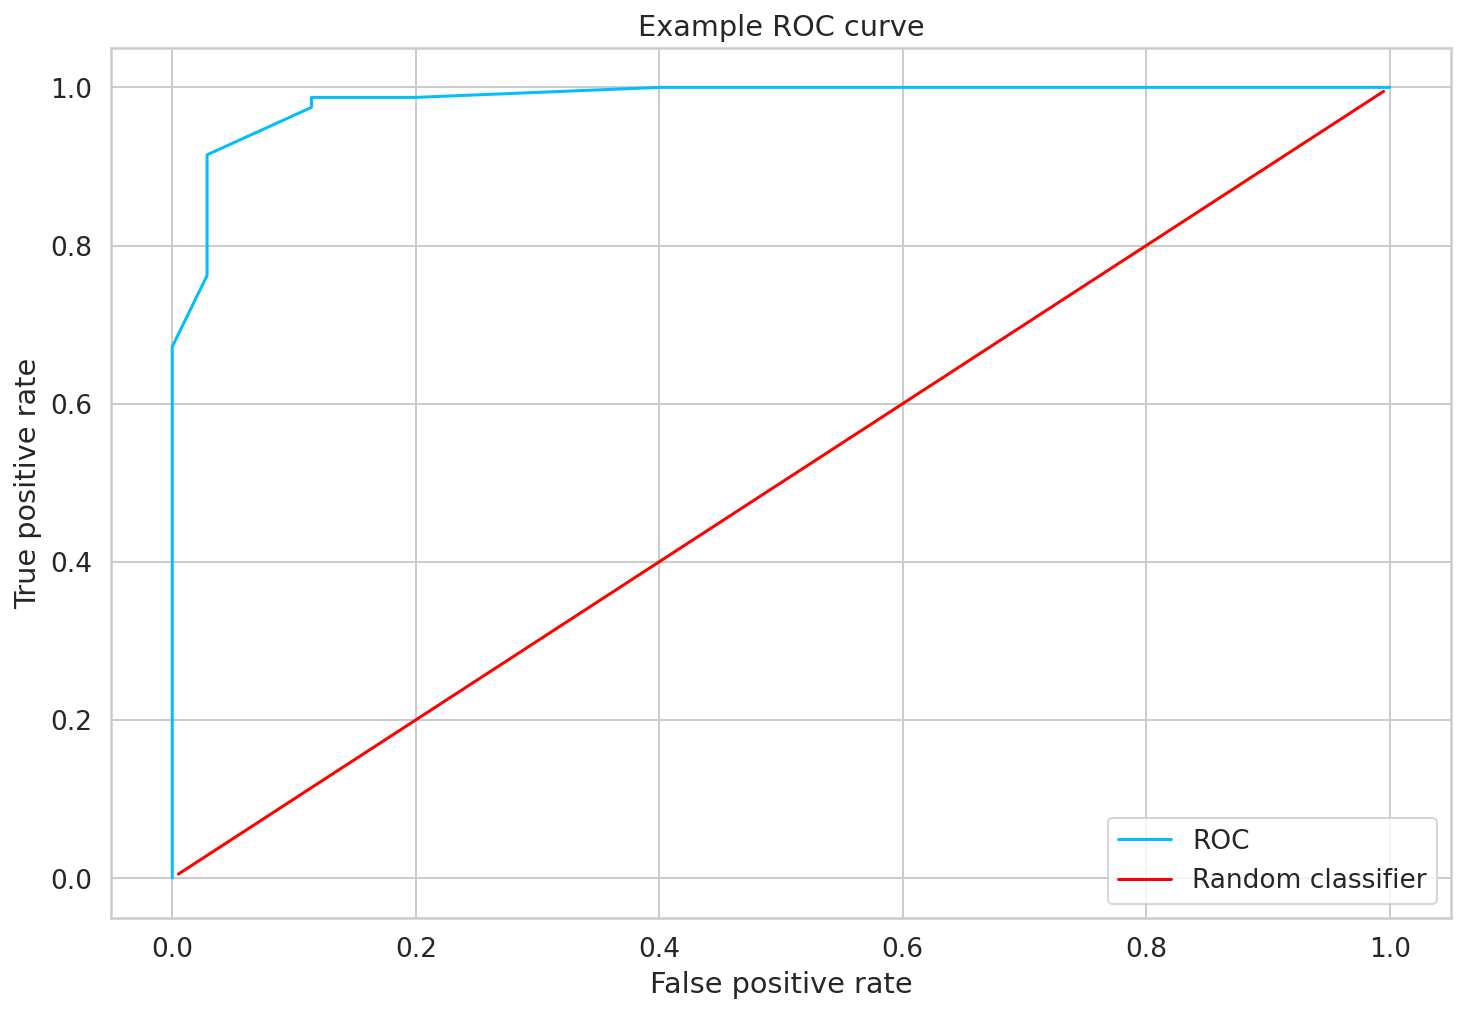

In [45]:
from sklearn import metrics
fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]
tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]
_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show();

Example ROC vaue of a trained classifier vs random classifier

# Training 
The beauty of PyTorch Lightning is that you can build a standard pipeline that you like and train (almost?) every model you might imagine. I prefer to use at least 3 components.

Checkpointing that saves the best model (based on validation loss):



In [46]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

Log the progress in TensorBoard:

In [47]:
logger = TensorBoardLogger("lightning_logs", name="tweets")

And early stopping triggers when the loss hasn’t improved for the last 2 epochs (you might want to remove/reconsider this when training on real-world projects):

In [48]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

**We** can start the training process:



In [49]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  #progress_bar_refresh_rate=30
)

TypeError: ignored

In [ ]:
trainer.fit(model, data_module)

NameError: ignored

# Running the code how I run it in jupyter lab 

preprocessing.py

The model improved for (only) 2 epochs. We’ll have to evaluate it to see whether it is any good. Let’s double-check the validation loss:



# Predictions 
I like to look at a small sample of predictions after the training is complete. This builds intuition about the quality of the predictions (qualitative evaluation).

Let’s load the best version (according to the validation loss) of our model:

In [ ]:
trained_model = TweetTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We put our model into “eval” mode, and we’re ready to make some predictions. Here’s the prediction on a sample (totally fictional) comment:

In [ ]:
test_comment = "retard retard retard hello hello hello"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

neutral: 0.07832329720258713
general criticism: 0.05474391579627991
disability shaming: 0.8872364163398743
racial prejudice: 0.09574278444051743
sexism: 0.10517227649688721
lgbtq+ phobic: 0.10428095608949661


In [ ]:
LABEL_COLUMNS

['neutral',
 'general criticism',
 'disability shaming',
 'racial prejudice',
 'sexism',
 'lgbtq+ phobic']

In [ ]:
test_prediction

array([0.0783233 , 0.05474392, 0.8872364 , 0.09574278, 0.10517228,
       0.10428096], dtype=float32)

# WEIGHTING SENTIMENT WITH BERT 

In [ ]:

tweet = "I think drinking tea past 8 pm is retarded! Too much caffeine!!"
re.findall(r"[\w']+|[.,!?;]", tweet)


['I',
 'think',
 'drinking',
 'tea',
 'past',
 '8',
 'pm',
 'is',
 'retarded',
 '!',
 'Too',
 'much',
 'caffeine',
 '!',
 '!']

In [ ]:
def generate_N_grams(text,ngram=1):
    words = re.findall(r"[\w']+|[.,!?;]", text)
    #words=[word for word in text.split(" ")]  
    temp=zip(*[words[i:] for i in range(0,ngram)])
    ans=[' '.join(ngram) for ngram in temp]
    return ans


tweet = "I think drinking tea past 8 pm is retarded! Too much caffeine!!"
#text = re.findall(r"[\w']+|[.,!?;]", tweet)
unigrams = generate_N_grams(tweet, 1) 
unigrams

['I',
 'think',
 'drinking',
 'tea',
 'past',
 '8',
 'pm',
 'is',
 'retarded',
 '!',
 'Too',
 'much',
 'caffeine',
 '!',
 '!']

In [ ]:
f"\033[95m'bitch'\033[00m"

"\x1b'bitch'\x1b"

In [ ]:

text = "this fat retarded black bitch thinks you should be forced to feed and house a bunch of violence foreign invaders. I strongly disagree"

def color_words(text):
  # define sentiment lists for each color 
  neutral_words = []
  general_criticism_words = []
  disability_shaming_words = []
  racist_words = []
  sexist_words = []
  lgbtq_words = []

  # remove punctutation 
  # tweet = re.findall(r"[\w']+|[.,!?;]", tweet)
  tweet = re.sub(r'[^\w\s]', '', text)
  # dictionary storing the count of each sentiment detected from BERT (increment by )0.5 because we use bigrams  
  count_dict = {'neutral_count': 0, 'general_criticism_count': 0, 'disability_count': 0, 'racist_count': 0, 'sexist_count': 0, 'lgbtq_count': 0}
  # first and last unigrams 
  unigrams = generate_N_grams(tweet, 1) 
  for unigram in unigrams:
    encoding = tokenizer.encode_plus(
    unigram,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt',
    )
    _, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
    test_prediction = test_prediction.flatten().numpy()
    # print(f'unigram: {unigram}, test_prediction: {test_prediction}')
    if test_prediction[0] > 0.5:
      count_dict['neutral_count'] += 1
      neutral_words.append(unigram)
    elif test_prediction[1] > 0.5:
      count_dict['general_criticism_count'] += 1
      general_criticism_words.append(unigram)
    elif test_prediction [2] > 0.5:
      count_dict['disability_count'] += 1
      disability_shaming_words.append(unigram)
    elif test_prediction[3] > 0.5:
      count_dict['racist_count'] += 1
      racist_words.append(unigram)
    elif test_prediction[4] > 0.5:
      count_dict['sexist_count'] += 1
      sexist_words.append(unigram)
    elif test_prediction[5] > 0.5:
      count_dict['lgbtq_count'] += 1
      lgbtq_words.append(unigram)

  # puncs = ['!','(',')',',','-','[',']','{','}',';',':','’', '”', '<' , '>','.','/','?','@','#','$','%','^','&','*','_','~']
  tweet = re.findall(r"[\w']+|[.,!?;]", text)
  string = ""

  for word in tweet:
    if word in lgbtq_words:
        string += print(f"\033[95m{word}\033[00m") + " "
    elif word in racist_words:
        string += print(f"\033[96m{word}\033[00m") + " "
    elif word in disability_shaming_words:
        string += f"\033[92m{word}\033[00m" + " "
    elif word in sexist_words:
        string += f"\033[93m{word}\033[00m" + " "
    elif word in general_criticism_words:
        string += f"\033[91m{word}\033[00m" + " "
    else:
        string += word + " "
  return string 

count_category(text)
color_words(text)
#print(f'neutral_words: {neutral_words}')

# break tweet into bigrams using generate_N_grams function 
# bigrams = generate_N_grams(tweet, 2) 
# for bigram in bigrams:
#   # encode bigrams and predict sentiment 
#   encoding = tokenizer.encode_plus(
#   bigram,
#   add_special_tokens=True,
#   max_length=512,
#   return_token_type_ids=False,
#   padding="max_length",
#   return_attention_mask=True,
#   return_tensors='pt',
#   )
#   _, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
#   test_prediction = test_prediction.flatten().numpy()
#   print(f'bigram: {bigram}, test_prediction: {test_prediction}')
#   if test_prediction[0] > 0.5:
#     count_dict['neutral_count'] += 0.5
#   elif test_prediction[1] > 0.5:
#     count_dict['general_criticism_count'] += 0.5
#   elif test_prediction [2] > 0.5:
#     count_dict['disability_count'] += 0.5
#   elif test_prediction[3] > 0.5:
#     count_dict['racist_count'] += 0.5
#   elif test_prediction[4] > 0.5:
#     count_dict['sexist_count'] += 0.5
#   elif test_prediction[5] > 0.5:
#     count_dict['lgbtq_count'] += 0.5
#   print(count_dict)


  # bigram = ' '.join(bigram)
  # print(bigram)
# for word in tweet.split():
#   print(word)

retarded


TypeError: ignored

In [ ]:

text = "this fat retarded black bitch thinks you should be forced to feed and house a bunch of violence foreign invaders. I strongly disagree"

def color_words(text):
  # define sentiment lists for each color 
  neutral_words = []
  general_criticism_words = []
  disability_shaming_words = []
  racist_words = []
  sexist_words = []
  lgbtq_words = []

  # remove punctutation 
  # tweet = re.findall(r"[\w']+|[.,!?;]", tweet)
  tweet = re.sub(r'[^\w\s]', '', text)
  # dictionary storing the count of each sentiment detected from BERT (increment by )0.5 because we use bigrams  
  count_dict = {'neutral_count': 0, 'general_criticism_count': 0, 'disability_count': 0, 'racist_count': 0, 'sexist_count': 0, 'lgbtq_count': 0}
  # first and last unigrams 
  unigrams = generate_N_grams(tweet, 1) 
  for unigram in unigrams:
    encoding = tokenizer.encode_plus(
    unigram,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt',
    )
    _, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
    test_prediction = test_prediction.flatten().numpy()
    # print(f'unigram: {unigram}, test_prediction: {test_prediction}')
    if test_prediction[0] > 0.5:
      count_dict['neutral_count'] += 1
      neutral_words.append(unigram)
    elif test_prediction[1] > 0.5:
      count_dict['general_criticism_count'] += 1
      general_criticism_words.append(unigram)
    elif test_prediction [2] > 0.5:
      count_dict['disability_count'] += 1
      disability_shaming_words.append(unigram)
    elif test_prediction[3] > 0.5:
      count_dict['racist_count'] += 1
      racist_words.append(unigram)
    elif test_prediction[4] > 0.5:
      count_dict['sexist_count'] += 1
      sexist_words.append(unigram)
    elif test_prediction[5] > 0.5:
      count_dict['lgbtq_count'] += 1
      lgbtq_words.append(unigram)

  # puncs = ['!','(',')',',','-','[',']','{','}',';',':','’', '”', '<' , '>','.','/','?','@','#','$','%','^','&','*','_','~']
  tweet = re.findall(r"[\w']+|[.,!?;]", text)


  for word in tweet:
    if word in lgbtq_words:
        print(f"\033[95m{word}\033[00m", end = ' ' )
    elif word in racist_words:
        print(f"\033[96m{word}\033[00m", end = ' ')
    elif word in disability_shaming_words:
        print(f"\033[92m{word}\033[00m", end = ' ')
    elif word in sexist_words:
        print(f"\033[93m{word}\033[00m", end = ' ')
    elif word in general_criticism_words:
        print(f"\033[91m{word}\033[00m", end =' ')
    else:
        print(word, end=' ')

count_category(text)
color_words(text)
#print(f'neutral_words: {neutral_words}')

# break tweet into bigrams using generate_N_grams function 
# bigrams = generate_N_grams(tweet, 2) 
# for bigram in bigrams:
#   # encode bigrams and predict sentiment 
#   encoding = tokenizer.encode_plus(
#   bigram,
#   add_special_tokens=True,
#   max_length=512,
#   return_token_type_ids=False,
#   padding="max_length",
#   return_attention_mask=True,
#   return_tensors='pt',
#   )
#   _, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
#   test_prediction = test_prediction.flatten().numpy()
#   print(f'bigram: {bigram}, test_prediction: {test_prediction}')
#   if test_prediction[0] > 0.5:
#     count_dict['neutral_count'] += 0.5
#   elif test_prediction[1] > 0.5:
#     count_dict['general_criticism_count'] += 0.5
#   elif test_prediction [2] > 0.5:
#     count_dict['disability_count'] += 0.5
#   elif test_prediction[3] > 0.5:
#     count_dict['racist_count'] += 0.5
#   elif test_prediction[4] > 0.5:
#     count_dict['sexist_count'] += 0.5
#   elif test_prediction[5] > 0.5:
#     count_dict['lgbtq_count'] += 0.5
#   print(count_dict)


  # bigram = ' '.join(bigram)
  # print(bigram)
# for word in tweet.split():
#   print(word)

this fat retarded black bitch thinks you should be forced to feed and house a bunch of violence foreign invaders . I strongly disagree 

In [ ]:
# text = "what a fat cunt."


# def color_words(text):
#   # define sentiment lists for each color 
#   neutral_words = []
#   general_criticism_words = []
#   disability_shaming_words = []
#   racist_words = []
#   sexist_words = []
#   lgbtq_words = []

#   # remove punctutation 
#   # tweet = re.findall(r"[\w']+|[.,!?;]", tweet)
  
#   tweet_gram = re.sub(r'[^\w\s]', '', text)
#   tweet = text.split(' ')
  
  
#   # dictionary storing the count of each sentiment detected from BERT (increment by )0.5 because we use bigrams  
#   count_dict = {'neutral_count': 0, 'general_criticism_count': 0, 'disability_count': 0, 'racist_count': 0, 'sexist_count': 0, 'lgbtq_count': 0}
#   # first and last unigrams 
#   unigrams = generate_N_grams(tweet_gram, 1) 
#   for unigram in unigrams:
#     encoding = tokenizer.encode_plus(
#     unigram,
#     add_special_tokens=True,
#     max_length=512,
#     return_token_type_ids=False,
#     padding="max_length",
#     return_attention_mask=True,
#     return_tensors='pt',
#     )
#     _, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
#     test_prediction = test_prediction.flatten().numpy()
#     # print(f'unigram: {unigram}, test_prediction: {test_prediction}')
#     if test_prediction[0] > 0.5:
#       count_dict['neutral_count'] += 1
#       neutral_words.append(unigram)
#     elif test_prediction[1] > 0.5:
#       count_dict['general_criticism_count'] += 1
#       general_criticism_words.append(unigram)
#     elif test_prediction [2] > 0.5:
#       count_dict['disability_count'] += 1
#       disability_shaming_words.append(unigram)
#     elif test_prediction[3] > 0.5:
#       count_dict['racist_count'] += 1
#       racist_words.append(unigram)
#     elif test_prediction[4] > 0.5:
#       count_dict['sexist_count'] += 1
#       sexist_words.append(unigram)
#     elif test_prediction[5] > 0.5:
#       count_dict['lgbtq_count'] += 1
#       lgbtq_words.append(unigram)

#   # puncs = ['!','(',')',',','-','[',']','{','}',';',':','’', '”', '<' , '>','.','/','?','@','#','$','%','^','&','*','_','~']
  
#   #tweet = re.findall(r"[\w']+|[.,!?;]", text)
  
#   # tweet = text.split(' ')


#   for word in tweet:
#     for text in lgbtq_words:
#       if text in word:
#         print(f"\033[95m{word}\033[00m" ,end = ' ' )
#       else:
#         print(word, end=' ')
#     for text in racist_words:
#       if text in word:
#         print(f"\033[96m{word}\033[00m" ,end = ' ')
#       else:
#         print(word, end=' ') 
#     for text in disability_shaming_words:
#       if text in word:
#         print(f"\033[92m{word}\033[00m", end =' ')
#       else:
#         print(word, end=' ')
#     for text in sexist_words:
#       if text in word:
#         print(f"\033[93m{word}\033[00m" , end= ' ')
#       else:
#         print(word, end=' ')
#     for text in general_criticism_words:
#       if text in word:
#         print(f"\033[91m{word}\033[00m", end = ' ')
#       else:
#         print(word, end=' ')
    
#     # if word in lgbtq_words:
#     #     print(f"\033[95m{word}\033[00m" ,end = '' )
#     # elif word in racist_words:
#     #     print(f"\033[96m{word}\033[00m" ,end = '')
#     # elif word in disability_shaming_words:
#     #     print(f"\033[92m{word}\033[00m", end ='')
#     # elif word in sexist_words:
#     #     print(f"\033[93m{word}\033[00m" , end= '')
#     # elif word in general_criticism_words:
#     #     print(f"\033[91m{word}\033[00m", end = '')
#     # else:
#     #     print(word, end=' ')

# count_category(text)
# color_words(text)

what a fat cunt. 

In [ ]:
text = "what a fat cunt. I hate her."
tweet = text.split(' ')
#tweet = re.findall(r"[\w']+|[.,!?;]", text)
tweet

['what', 'a', 'fat', 'cunt.', 'I', 'hate', 'her.']

In [ ]:
'text' in 'text!'

True

In [ ]:
test_prediction

Tweet: Lebron james was eating a burger and then he slipped and fell. And so then I said you're a retard


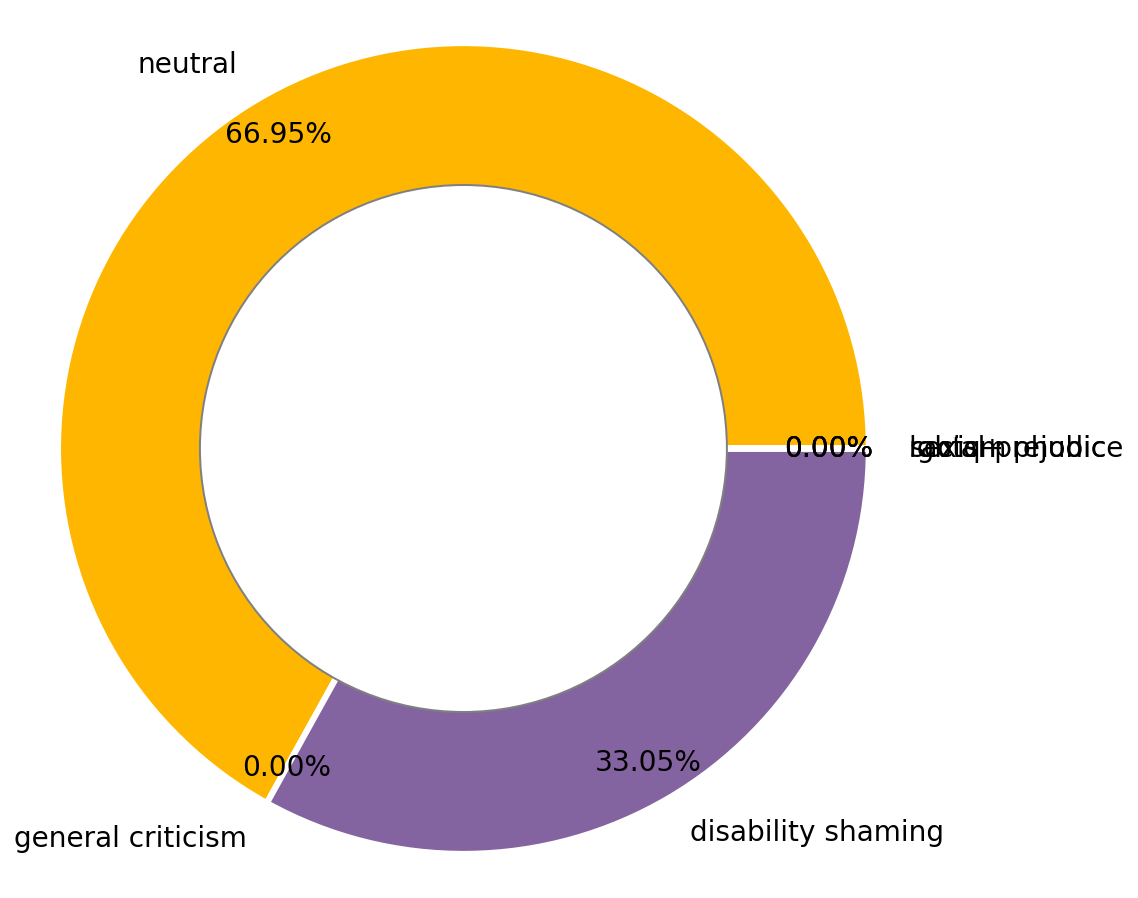

Lebron james was eating a burger and then he slipped and fell . And so then I said you're a retard 

(None, None)

In [ ]:




def return_distribution(test_comment):
  
  encoding = tokenizer.encode_plus(
    test_comment,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt',
  )
  _, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
  test_prediction = test_prediction.flatten().numpy()

  # multiply the original outputs by the term frequency (TF) of each category
    
  count_dict = count_category(test_comment)


  neutral_score = count_dict['neutral_count']*test_prediction[0]
  general_criticism_score = count_dict['general_criticism_count']*test_prediction[1]
  weighted_disability_score = count_dict['disability_count']*test_prediction[2]
  weighted_racist_score = count_dict['racist_count']*test_prediction[3]
  weighted_sexist_score = count_dict['sexist_count']*test_prediction[4]
  weighted_lgbtq_score = count_dict['lgbtq_count']*test_prediction[5]

  #if neutral_score < 0.5 or general_criticism_score <0.5:

  weighted_test_prediction = np.array([neutral_score, general_criticism_score, weighted_disability_score,weighted_racist_score,weighted_sexist_score,weighted_lgbtq_score])
  
    
  
  pred_dict = {'Sentiment': LABEL_COLUMNS, 'Probability': weighted_test_prediction}
  pred_df = pd.DataFrame(pred_dict)

  print(f'Tweet: {test_comment}')
  plt.figure(figsize=(8, 8)) # change the size of a figure
  # The slices will be ordered and plotted counter-clockwise.
  labels = pred_df['Sentiment']
  sizes = pred_df['Probability']
  colors = ['#FFB600', '#09A0DA','#8464a0', 'red', 'green', 'pink'] #define colors of three donut pieces
  explode = (0, 0,0,0,0,0) # explode a slice if required
  textprops = {'fontsize':14, 'color':'black'} # Font size of text in donut chart
  plt.pie(sizes, explode=explode, labels=labels, colors=colors,
  autopct='%.2f%%', # Show data in 0.00%
  pctdistance =0.9,
  shadow=False,
  textprops =textprops,
  wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},)

  #draw a circle at the center of pie to make it look like a donut
  centre_circle = plt.Circle((0,0),0.65,color='grey', fc='white',linewidth=1.00)
  fig = plt.gcf()
  fig.gca().add_artist(centre_circle)
  plt.axis('equal') # Set aspect ratio to be equal so that pie is drawn as a circle.
  display = plt.show()
  return display, color_words(test_comment)


return_distribution("Lebron james was eating a burger and then he slipped and fell. And so then I said you're a retard")

In [ ]:
"I think fags, niggers, and homos".split()

['I', 'think', 'fags,', 'niggers,', 'and', 'homos']

Looks good. This one is pretty clean. We’ll reduce the noise of the predictions by thresholding (0.5) them. We’ll take only tag predictions above (or equal) to the threshold. Let’s try something toxic:

In [ ]:
THRESHOLD = 0.5
test_comment = "You are such a loser! You'll regret everything you've done to me!"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  if prediction < THRESHOLD:
    continue
  print(f"{label}: {prediction}")

# Evaluation 

Let’s get a more complete overview of the performance of our model. We’ll start by taking all predictions and labels from the validation set:



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
val_dataset = TweetsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
predictions = []
labels = []
for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/1132 [00:00<?, ?it/s]

One simple metric is the accuracy of the model:

In [ ]:
predictions

tensor([[0.0067, 0.0074, 0.0086, 0.0194, 0.9929, 0.0115],
        [0.0066, 0.0074, 0.0097, 0.0193, 0.9938, 0.0126],
        [0.0696, 0.0620, 0.0636, 0.0786, 0.0730, 0.9119],
        ...,
        [0.8257, 0.1233, 0.0258, 0.0452, 0.0486, 0.0204],
        [0.0102, 0.0174, 0.0231, 0.9461, 0.9798, 0.0292],
        [0.0318, 0.0237, 0.0197, 0.9682, 0.0921, 0.0392]])

In [ ]:
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.9787)

That’s great, but you should take this result with a grain of salt. We have a very imbalanced dataset. Let’s check the ROC for each tag:

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
neutral: 0.9865038394927979
general criticism: 0.9644076824188232
disability shaming: 0.9970425963401794
racial prejudice: 0.9690312147140503
sexism: 0.995820939540863
lgbtq+ phobic: 0.9456567764282227


Very good results, but just before we go party, let’s check the classification report for each class. To make this work, we must apply thresholding to the predictions:

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > THRESHOLD, upper, lower)
print(classification_report(
  y_true,
  y_pred,
  target_names=LABEL_COLUMNS,
  zero_division=0
))

                    precision    recall  f1-score   support

           neutral       0.77      0.92      0.84       121
 general criticism       0.62      0.33      0.43        45
disability shaming       1.00      0.90      0.95        21
  racial prejudice       0.96      0.85      0.90       217
            sexism       1.00      0.98      0.99       783
     lgbtq+ phobic       0.98      0.86      0.92        51

         micro avg       0.96      0.92      0.94      1238
         macro avg       0.89      0.81      0.84      1238
      weighted avg       0.96      0.92      0.94      1238
       samples avg       0.94      0.93      0.93      1238



In [ ]:
y_true

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 1, 0]], dtype=int32)

AttributeError: ignored

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
preds = predictions[:, LABEL_COLUMNS]



#y_probas = predictions[:, i]
skplt.metrics.plot_roc_curve(y_true, predictions)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


ValueError: ignored

# Confusion Matrix 

In [ ]:
# confusion matrix 
def show_confusion_matrix(multilabel_confusion_matrix):
  hmap = sns.heatmap(multilabel_confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = multilabel_confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index= LABEL_COLUMNS, columns= LABEL_COLUMNS)
show_confusion_matrix(cm)

ValueError: ignored

In [ ]:
cm = multilabel_confusion_matrix(y_true, y_pred)
print()


[[[ 978   33]
  [  10  111]]

 [[1078    9]
  [  30   15]]

 [[1111    0]
  [   2   19]]

 [[ 908    7]
  [  32  185]]

 [[ 347    2]
  [  12  771]]

 [[1080    1]
  [   7   44]]]


In [ ]:
x = np.reshape(y_pred, (-1,2))

In [ ]:
y_pred[1]

array([0, 0, 0, 0, 1, 0])

In [ ]:
y_true.shape

(1132, 6)

In [ ]:
val_dataset.pred

AttributeError: ignored